# Setup

In [1]:
%pip install magtrack matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import magtrack
from magtrack.simulation import simulate_beads
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

## Simulation
To start we will simulate a stack of 100 images of beads. In each frame the bead will drift slightly to the right.

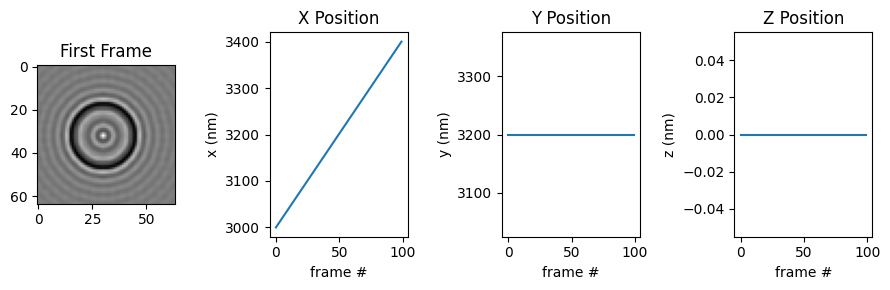

In [3]:
n = 100
roi = 64
nm_per_px = 100.0

xy_offset = roi*nm_per_px/2
x_true = np.linspace(-200, 200, n)
y_true = np.zeros_like(x_true)
z_true = np.zeros_like(x_true)
xyz_true = np.stack([x_true, y_true, z_true], axis=1)
stack = simulate_beads(xyz_true, size_px=roi, nm_per_px=nm_per_px)
x_true += xy_offset
y_true += xy_offset
first_image = stack[:, :, 0]

plt.figure(figsize=(9, 3))

plt.subplot(1, 4, 1)
plt.imshow(first_image, cmap='gray')
plt.title('First Frame')

plt.subplot(1, 4, 2)
plt.plot(x_true)
plt.title('X Position')
plt.ylabel('x (nm)')
plt.xlabel('frame #')

plt.subplot(1, 4, 3)
plt.plot(y_true)
plt.title('Y Position')
plt.ylabel('y (nm)')
plt.xlabel('frame #')

plt.subplot(1, 4, 4)
plt.plot(z_true)
plt.title('Z Position')
plt.ylabel('z (nm)')
plt.xlabel('frame #')

plt.tight_layout()
plt.show()

# Example 1: Get XY with Center-of-Mass with CPU
We will now try getting a rough xy position with the center_of_mass algorithm

In [4]:
x_fit, y_fit = magtrack.center_of_mass(stack, background="median")
x_fit *= nm_per_px
y_fit *= nm_per_px

print(f'x: {x_fit}, y: {y_fit}')

x: [3033.06374433 3035.88020067 3038.15549583 3039.81764004 3041.82378038
 3044.55044985 3048.18099845 3051.47690781 3055.1787351  3059.38617355
 3063.09842163 3066.37480184 3070.23342337 3074.52635642 3077.98665504
 3081.34301355 3085.22842164 3089.49561948 3093.28669937 3096.48759584
 3099.82415879 3102.53055807 3104.24159746 3106.01176805 3108.26905102
 3111.17749206 3113.81296061 3115.95993566 3117.59203282 3119.95116491
 3122.98689444 3126.36798283 3129.89937977 3133.80608586 3138.16442454
 3141.78926314 3145.23189739 3149.45126278 3153.85775009 3157.31724378
 3160.90791315 3165.0880415  3169.15691851 3172.82699623 3176.10258344
 3179.32676291 3181.94322663 3183.5859507  3185.61060711 3188.10314752
 3191.10523907 3193.45580521 3195.37772367 3196.96941017 3199.48143664
 3202.6195092  3205.87991083 3209.56902006 3213.66048146 3217.74759035
 3221.17670201 3224.45152291 3228.68526186 3232.79552326 3236.15265214
 3239.55278984 3243.81267083 3247.58840013 3251.02061739 3254.61458816
 32

Now we will plot those out

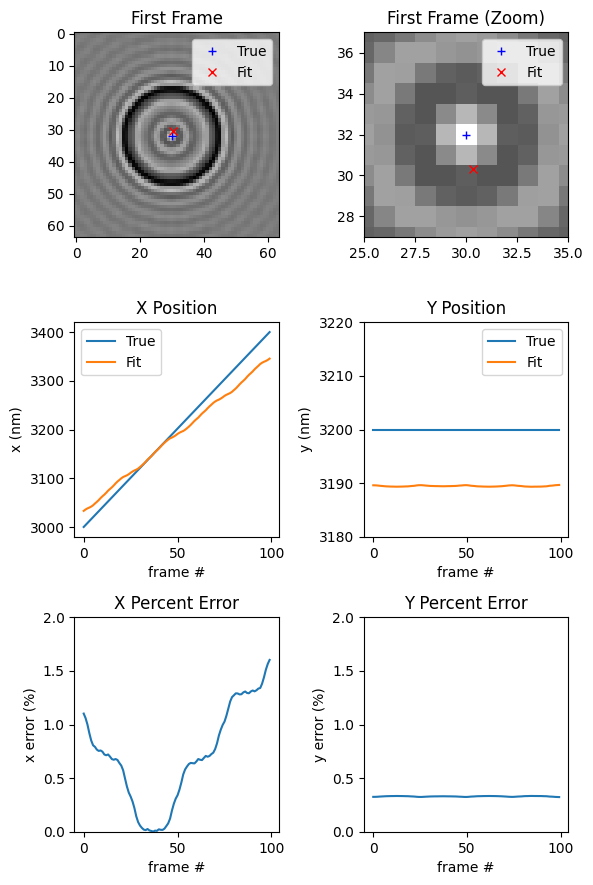

In [5]:
plt.figure(figsize=(6, 9))

plt.subplot(3, 2, 1)
plt.imshow(first_image, cmap='gray')
plt.plot(x_true[0]/nm_per_px, y_true[0]/nm_per_px, 'b+', label='True')
plt.plot(x_fit[0]/nm_per_px, x_fit[0]/nm_per_px, 'rx', label='Fit')
plt.legend()
plt.title('First Frame')

plt.subplot(3, 2, 2)
plt.imshow(first_image, cmap='gray')
plt.plot(x_true[0]/nm_per_px, y_true[0]/nm_per_px, 'b+', label='True')
plt.plot(x_fit[0]/nm_per_px, x_fit[0]/nm_per_px, 'rx', label='Fit')
plt.xlim(x_true[0]/nm_per_px-5, x_true[0]/nm_per_px+5)
plt.ylim(y_true[0]/nm_per_px-5, y_true[0]/nm_per_px+5)
plt.legend()
plt.title('First Frame (Zoom)')

plt.subplot(3, 2, 3)
plt.plot(x_true, label='True')
plt.plot(x_fit, label='Fit')
plt.legend()
plt.title('X Position')
plt.ylabel('x (nm)')
plt.xlabel('frame #')
plt.ylim(x_true.min()-20, x_true.max()+20)

plt.subplot(3, 2, 4)
plt.plot(y_true, label='True')
plt.plot(y_fit, label='Fit')
plt.legend()
plt.title('Y Position')
plt.ylabel('y (nm)')
plt.xlabel('frame #')
plt.ylim(y_true.min()-20, y_true.max()+20)

plt.subplot(3, 2, 5)
plt.plot(abs(x_true-x_fit)/x_true*100)
plt.title('X Percent Error')
plt.ylabel('x error (%)')
plt.xlabel('frame #')
plt.ylim(0, 2)

plt.subplot(3, 2, 6)
plt.plot(abs(y_true-y_fit)/y_true*100)
plt.title('Y Percent Error')
plt.ylabel('y error (%)')
plt.xlabel('frame #')
plt.ylim(0, 2)

plt.tight_layout()
plt.show()

# Example 2: Refine the XY using sub-pixel auto convolution on the GPU
You can run any magtrack function on the CPU or GPU. The GPU is often much faster. If you are using Google Colab you will need to change the GPU by going to Runtime → Change runtime type → GPU. If you get stuck, just move on to the next example which uses the CPU.

In [6]:
# Verify a GPU exists
try:
  cp.cuda.runtime.getDeviceCount()
except Exception:
  print('Error! '*10 + '\n')
  print("No GPU runtime.\n")
  print("In Colab: Runtime → Change runtime type → GPU. \n\n")
else:
  dev = cp.cuda.runtime.getDevice()
  props = cp.cuda.runtime.getDeviceProperties(dev)
  name = props["name"].decode() if isinstance(props["name"], (bytes, bytearray)) else props["name"]
  print(f"GPU: {name} | CC {props['major']}.{props['minor']} | {props['totalGlobalMem']/1e9:.1f} GB")

GPU: NVIDIA GeForce RTX 3070 | CC 8.6 | 8.6 GB


In [7]:
# Move the stack to the GPU's RAM
stack_gpu = cp.asarray(stack)

# Estimate the XY position with the center-of-mass
x_com_gpu, y_com_gpu = magtrack.center_of_mass(stack_gpu)
x_com = cp.asnumpy(x_com_gpu) * nm_per_px # Move back to regular RAM
y_com = cp.asnumpy(y_com_gpu) * nm_per_px

# Get a better estimate with the sub-pixel auto-convolution
x_ac_gpu, y_ac_gpu = magtrack.auto_conv_para_fit(stack_gpu, x_com_gpu, y_com_gpu)
x_ac = cp.asnumpy(x_ac_gpu) * nm_per_px
y_ac = cp.asnumpy(y_ac_gpu) * nm_per_px

# Finally, we can measure the average percent error with each method
x_err = float(np.mean(np.abs(x_com - x_true) / x_true * 100))
y_err = float(np.mean(np.abs(y_com - y_true) / y_true * 100))
print(f'Center-of-mass error:    x: {x_err:.3f}%, y: {y_err:.3f}%')
x_err = float(np.mean(np.abs(x_ac - x_true) / x_true * 100))
y_err = float(np.mean(np.abs(y_ac - y_true) / y_true * 100))
print(f'Auto-convolution error:  x: {x_err:.3f}%, y: {y_err:.3f}%')

Center-of-mass error:    x: 3.400%, y: 1.609%
Auto-convolution error:  x: 0.041%, y: 0.001%


# Example 3: Refine XY on the CPU with Quadratic Interpolation
This example keeps everything on the CPU so that it works on any computer. We start with the center-of-mass positions
and then call `magtrack.qi_refine_xy` to get smoother, sub-pixel estimates. The steps below show how to
prepare the inputs, run the function, and read the results.

1. **Reuse the simulated stack** from the setup cells above.
2. **Get starting positions** with `magtrack.center_of_mass`.
3. **Refine the coordinates** by passing the stack and starting points into `qi_refine_xy`.
4. **Convert the refined values to nanometers** (nm) so they match the `x_true` and `y_true` arrays.
5. **Compare the average percent error** to see the improvement over the basic center-of-mass result.

Feel free to run this cell multiple times—the commands are safe to rerun and do not change anything else in the notebook.


Center-of-mass average error:        x = 0.702% | y = 0.330%
Quadratic interpolation average error: x = 0.046% | y = 0.010%


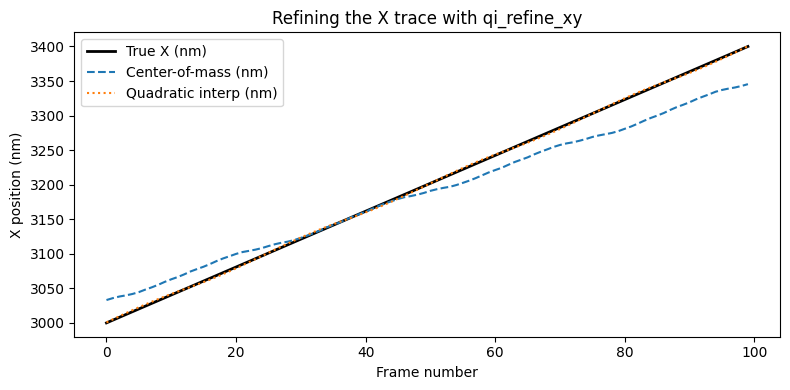

In [8]:
# Step 1 & 2: get starting positions in pixel units
x_com_px, y_com_px = magtrack.center_of_mass(stack, background="median")

# Step 3: refine with quadratic interpolation on the CPU
x_qi_px, y_qi_px = magtrack.qi_refine_xy(stack, x_com_px, y_com_px)
x_qi_px, y_qi_px = magtrack.qi_refine_xy(stack, x_qi_px, y_qi_px)
x_qi_px, y_qi_px = magtrack.qi_refine_xy(stack, x_qi_px, y_qi_px)

# Step 4: convert everything to nanometers for an apples-to-apples comparison
x_com_nm = x_com_px * nm_per_px
y_com_nm = y_com_px * nm_per_px
x_qi_nm = x_qi_px * nm_per_px
y_qi_nm = y_qi_px * nm_per_px

# Step 5: check how much accuracy we gained
def percent_error(true_values, measured_values):
    true_values = np.asarray(true_values, dtype=float)
    measured_values = np.asarray(measured_values, dtype=float)
    denominator = np.maximum(np.abs(true_values), 1e-9)
    return float(np.mean(np.abs(true_values - measured_values) / denominator) * 100.0)

x_err_com = percent_error(x_true, x_com_nm)
y_err_com = percent_error(y_true, y_com_nm)
x_err_qi = percent_error(x_true, x_qi_nm)
y_err_qi = percent_error(y_true, y_qi_nm)

print(f"Center-of-mass average error:        x = {x_err_com:.3f}% | y = {y_err_com:.3f}%")
print(f"Quadratic interpolation average error: x = {x_err_qi:.3f}% | y = {y_err_qi:.3f}%")

# Bonus: plot the refined positions so you can see the smoother trace
plt.figure(figsize=(8, 4))
plt.plot(x_true, label='True X (nm)', color='black', linewidth=2)
plt.plot(x_com_nm, label='Center-of-mass (nm)', linestyle='--')
plt.plot(x_qi_nm, label='Quadratic interp (nm)', linestyle=':')
plt.xlabel('Frame number')
plt.ylabel('X position (nm)')
plt.title('Refining the X trace with qi_refine_xy')
plt.legend()
plt.tight_layout()
plt.show()


# Example 4: Build a Z-LUT for axial fitting
This final example shows how to turn simulated bead images into the lookup table
that `magtrack.lookup_z_para_fit` expects. We will create a stack that sweeps a bead
through a range of z-positions, convert each frame into a radial profile, and pack
those profiles into a Z-LUT (Z look-up table).


In [9]:
# Simulate a reference stack that scans the bead in z
z_reference = np.arange(-5000, 5100, 100)  # nanometers
xyz_reference = np.column_stack([
    np.zeros_like(z_reference),
    np.zeros_like(z_reference),
    z_reference,
])
reference_stack = simulate_beads(xyz_reference, size_px=roi, nm_per_px=nm_per_px)

# Convert each frame into a radial profile centered on the bead
center_px = np.full(z_reference.shape, roi / 2, dtype=float)
reference_profiles = magtrack.radial_profile(
    reference_stack, center_px, center_px
)

# Assemble the Z-LUT: the first row stores the z positions,
# the remaining rows contain the radial profiles
zlut = np.vstack([z_reference, reference_profiles])
print(f'Z-LUT shape: {zlut.shape}')

Z-LUT shape: (33, 101)


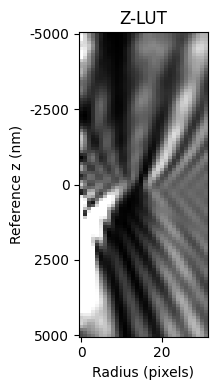

In [10]:
plt.figure(figsize=(6, 4))
plt.imshow(reference_profiles.T, cmap='gray', vmin=0, vmax=1, aspect=0.75)
plt.ylabel('Reference z (nm)')
plt.xlabel('Radius (pixels)')
plt.title('Z-LUT')
y_ticks = np.linspace(0, reference_profiles.shape[1]-1, 5).astype(int)
plt.yticks(y_ticks)
plt.gca().set_yticklabels(z_reference[y_ticks])
plt.tight_layout()
plt.show()


With the Z-LUT prepared, we can analyze a fresh stack, extract its radial profiles,
and estimate the bead's axial position. The lookup function returns a sub-frame
interpolation of the best matching reference profiles.


In [11]:
# Create a new stack with a different z trajectory
z_true_eval = np.linspace(-450, 450, 15) + 40.0 * np.sin(np.linspace(0, 2 * np.pi, 15))
xyz_eval = np.column_stack([
    np.zeros_like(z_true_eval),
    np.zeros_like(z_true_eval),
    z_true_eval,
])
eval_stack = simulate_beads(xyz_eval, size_px=roi, nm_per_px=nm_per_px)

eval_profiles = magtrack.radial_profile(
    eval_stack, np.full(z_true_eval.shape, roi / 2, dtype=float),
    np.full(z_true_eval.shape, roi / 2, dtype=float), oversample=2
)
z_fit = magtrack.lookup_z_para_fit(eval_profiles, zlut)

for idx, (true_z, fit_z) in enumerate(zip(z_true_eval, z_fit)):
    print(f'Frame {idx:02d} | true z = {true_z:+7.2f} nm | fitted z = {fit_z:+7.2f} nm')

plt.figure(figsize=(6, 3))
plt.plot(z_true_eval, label='True z (nm)', linewidth=2)
plt.plot(z_fit, label='Fitted z (nm)', linestyle='--')
plt.xlabel('Frame number')
plt.ylabel('Axial position (nm)')
plt.title('Axial fit from lookup_z_para_fit')
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\lond11\Documents\MagScope and MagTrack\MagTrack\magtrack\core.py:74: RuntimeWarning: invalid value encountered in divide
  bin_means /= bin_counts


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 31 is different from 63)